# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [18]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [19]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal
tt_plot = 0. : 0.01 : 20000.

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [20]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [21]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

# **Figure 5**

# Simu noisy model instantaneous Na Kd only

In [22]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0. # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0. # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]    

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_NaKdi = solve(prob; maxiters=1e9);

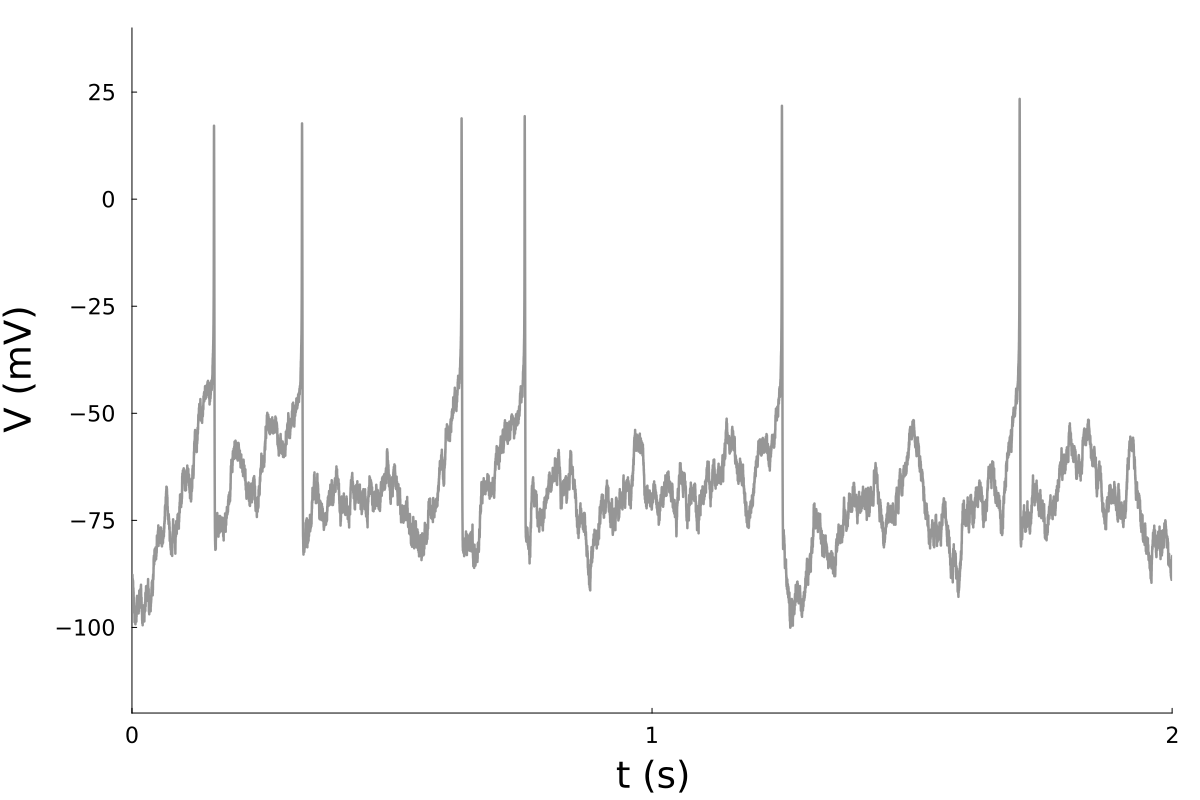

In [23]:
# Retrieving variables
x         = sol_NaKdi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt_plot./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-120, 40), 
    margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=([17.6, 18.6, 19.6], 
            ["0", "1", "2"]))
ylabel!("V (mV)")
xlabel!("t (s)")
display(voltage)
# savefig(voltage, "./figures/fig5_full_trace_NaKd.pdf")
# savefig(voltage, "./figures/fig5_full_trace_NaKd.svg")

# Simu noisy model instantaneous with SK

In [24]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0. # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]


# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_SKi = solve(prob; maxiters=1e9);

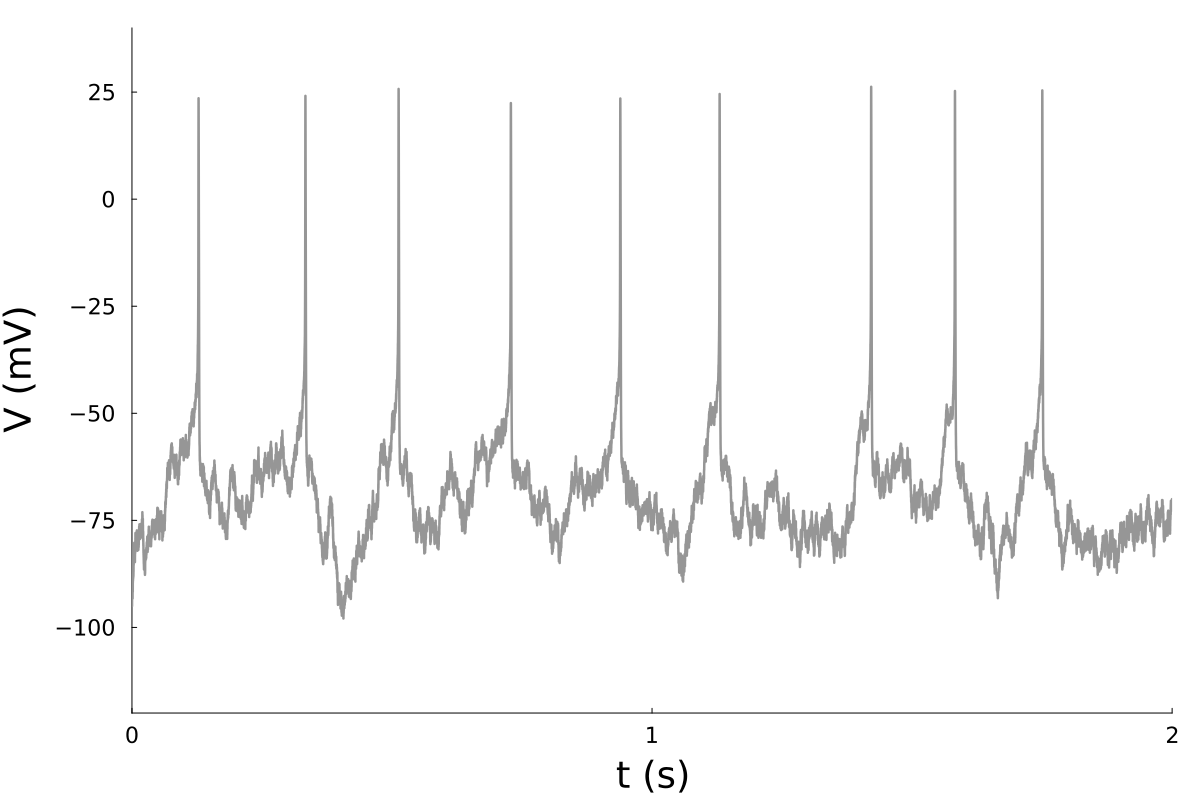

In [25]:
# Retrieving variables
x         = sol_SKi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt_plot./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-120, 40), 
    margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=([17.6, 18.6, 19.6], 
            ["0", "1", "2"]))
ylabel!("V (mV)")
xlabel!("t (s)")
display(voltage)
# savefig(voltage, "./figures/fig5_full_trace_SK.pdf")
# savefig(voltage, "./figures/fig5_full_trace_SK.svg")

# Simu noisy model instantaneous with H

In [26]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_Hi = solve(prob; maxiters=1e9);

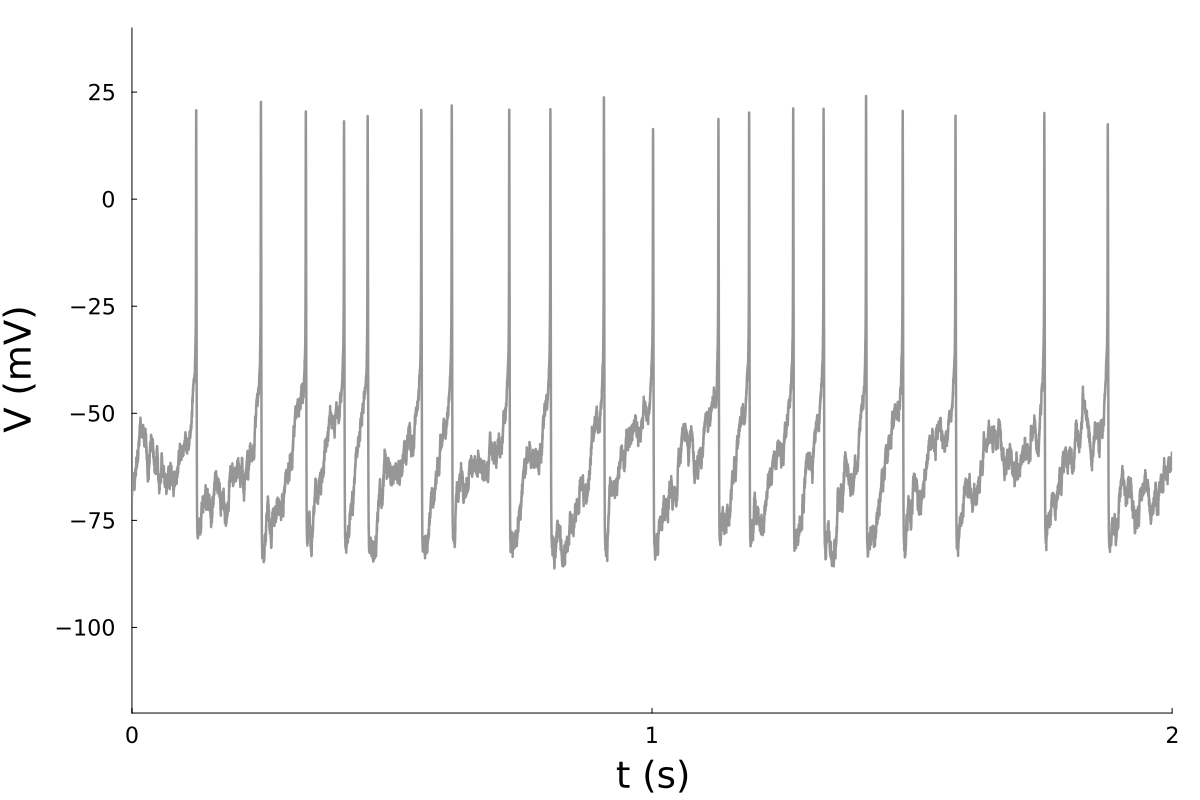

In [27]:
# Retrieving variables
x         = sol_Hi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt_plot./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-120, 40), 
    margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=([17.6, 18.6, 19.6], 
            ["0", "1", "2"]))
ylabel!("V (mV)")
xlabel!("t (s)")
display(voltage)
# savefig(voltage, "./figures/fig5_full_trace_H.pdf")
# savefig(voltage, "./figures/fig5_full_trace_H.svg")

# Simu noisy model instantaneous with H and A

In [28]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 0. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0. # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_HAi = solve(prob; maxiters=1e9);

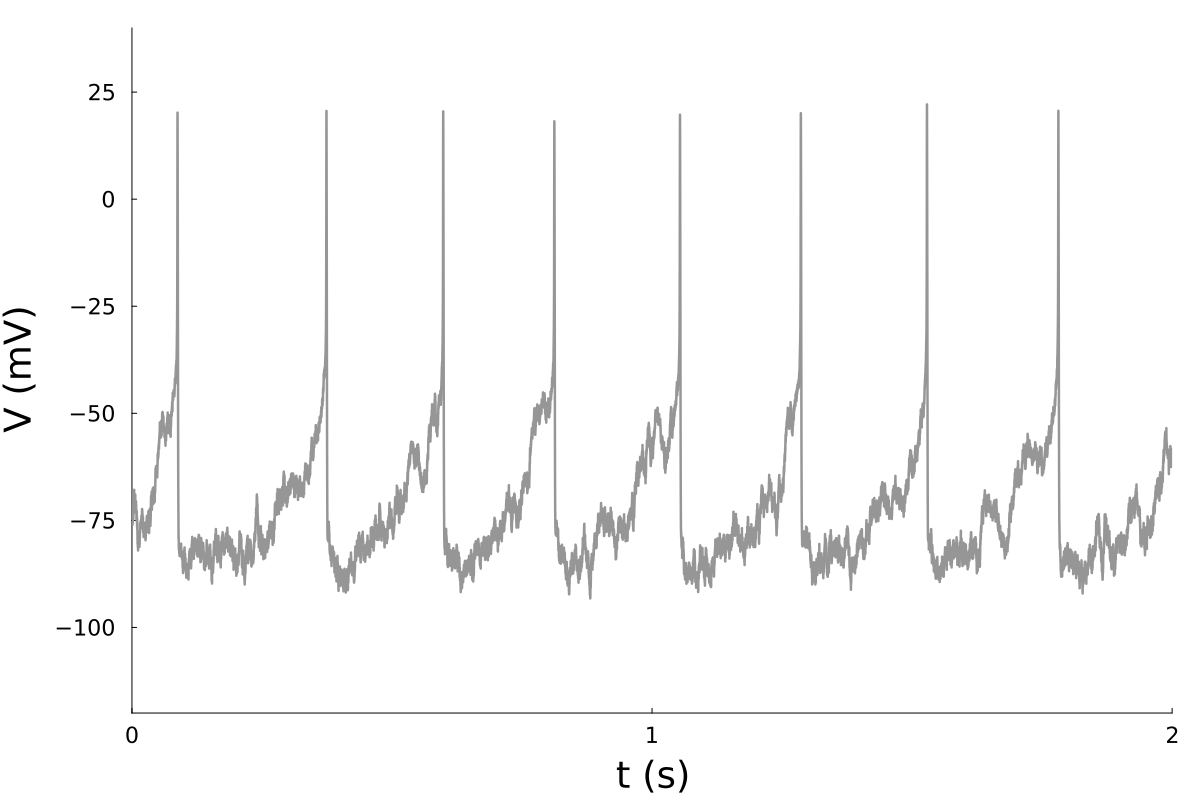

In [29]:
# Retrieving variables
x         = sol_HAi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt_plot./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-120, 40), 
    margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=([17.6, 18.6, 19.6], 
            ["0", "1", "2"]))
ylabel!("V (mV)")
xlabel!("t (s)")
display(voltage)
# savefig(voltage, "./figures/fig5_full_trace_HA.pdf")
# savefig(voltage, "./figures/fig5_full_trace_HA.svg")

# Simu noisy model instantaneous with H and SK

In [30]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 0. # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_HSKi = solve(prob; maxiters=1e9);

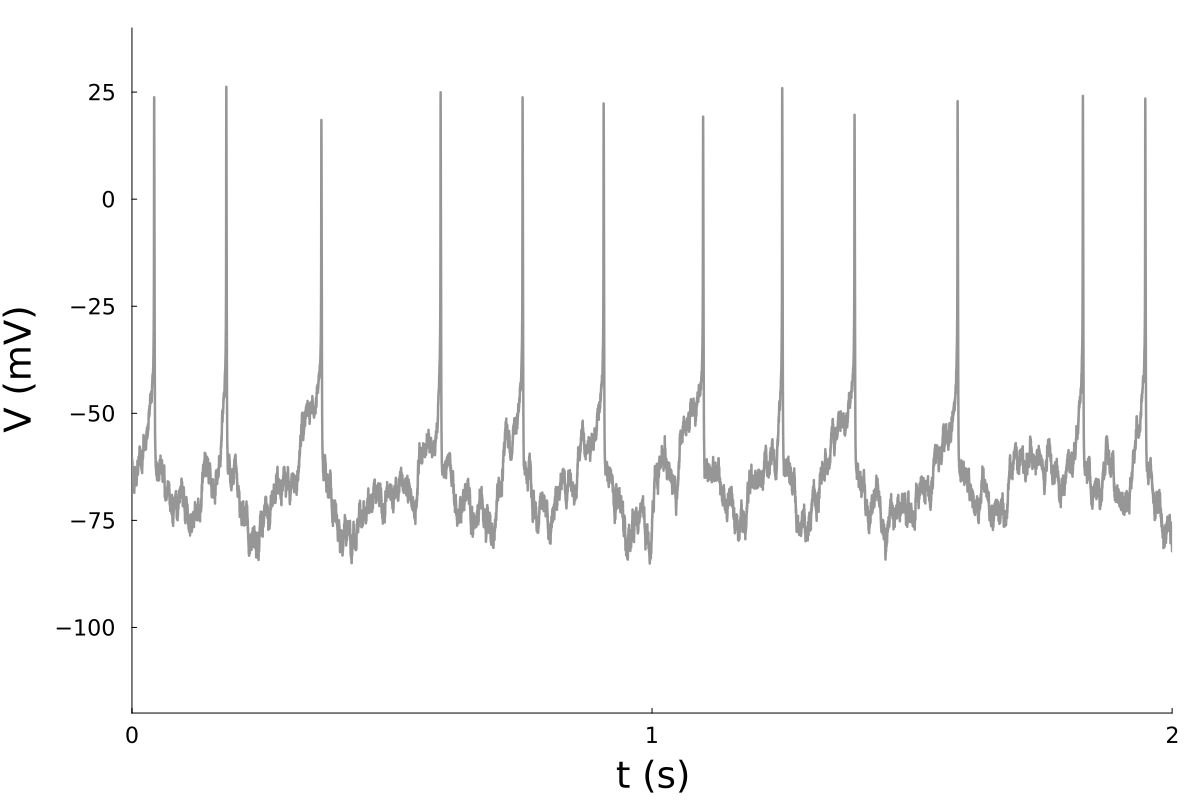

In [31]:
# Retrieving variables
x         = sol_HSKi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt_plot./1e3, V_plot, linewidth=2.5, color=myGray, legend=false, ylims=(-120, 40), 
    margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=([17.6, 18.6, 19.6], 
            ["0", "1", "2"]))
ylabel!("V (mV)")
xlabel!("t (s)")
display(voltage)
# savefig(voltage, "./figures/fig5_full_trace_HSK.pdf")
# savefig(voltage, "./figures/fig5_full_trace_HSK.svg")

# Simu noisy model instantaneous with all

In [32]:
gNa        = 25. # Sodium current maximal conductance
gCaL       = 1. # L-type calcium current maximal conductance
gKd        = 10. # Delayed-rectifier potassium current maximal conductance
gKA        = 1.68 # A-type potassium current maximal conductance
gKERG      = 0.13 # ERG current maximal conductance
gKSK       = 0.3 # SK current maximal conductance
gH         = 0.078 # H current maximal conductance
gLNS       = 0.01 # Leak non specific current maximal conductance
gLCa       = 0.00245 # Leak calcium current maximal conductance
gPacemaker = 5 # Pacemaker current maximal conductance

# Parameter vector for simulations
NoiseIntensity = 20
p = (NoisyFunction(NoiseIntensity), gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker)

# Initial conditions
V0 = 0.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), Ca0]

# Simulation
prob = ODEProblem(DA_ODE_true_instant, x0, tspan, p) # Describing the problem
sol_AHSKi = solve(prob; maxiters=1e9);

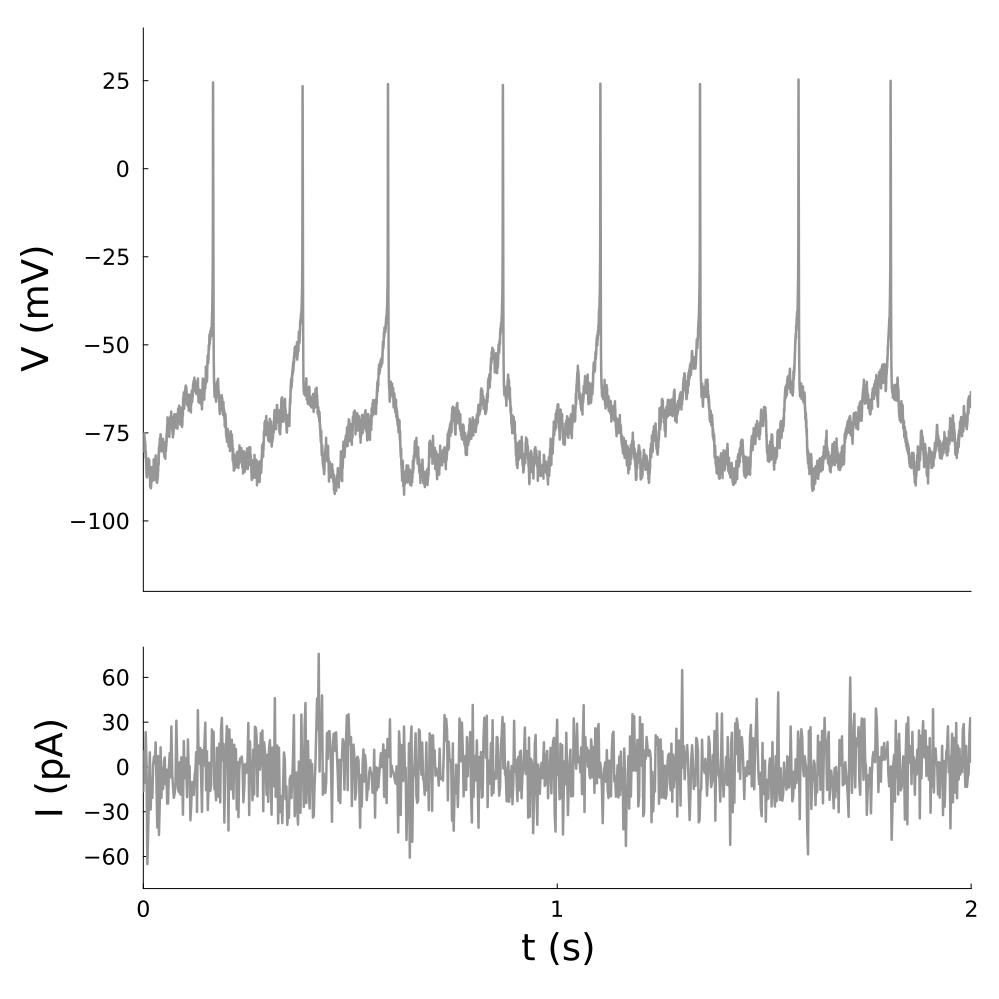

In [33]:
# Retrieving variables
x         = sol_AHSKi(tt_plot)
V_plot    = x[1, :]
voltage = plot(tt./1e3, V_plot, linewidth=2.5, color=myGray, 
    legend=false, ylims=(-120, 40), margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), xticks=false)
ylabel!("V (mV)")

tt_reduced = range(first(tt), stop=last(tt), length=10000)
current = plot(tt_reduced./1e3, NoisyFunction(NoiseIntensity).(tt_reduced), linewidth=2.5, 
    color=myGray, legend=false, margins=20Plots.px, size=(1200, 800), xlims=(17.6, 19.6), 
    xticks=([17.6, 18.6, 19.6], ["0", "1", "2"]))
ylabel!("I (pA)")
xlabel!("t (s)")

l = @layout [
    a{1.0*w, 0.70*h}
    b{1.0*w, 0.30*h}
]
VI = plot(voltage, current, layout=l, size=(1000, 1000), margins=20Plots.px, xlims=(17.6, 19.6))
display(VI)
# savefig(VI, "./figures/fig5_full_trace_AHSK.pdf")
# savefig(VI, "./figures/fig5_full_trace_AHSK.svg")